## **5주차 복습 코드2**

[실습명: 네이버 쇼핑 리뷰 감성분류]


## 네이버 쇼핑 리뷰 감성 분류

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

In [ ]:
# mecab 설치

!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 17.58 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.6/465.6 KB 16.3 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2023-02-06 08:55:36--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22cd:e0db, 2406:da00:ff00:

In [ ]:
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 데이터 로드

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f21a9071670>)

In [ ]:
total_data = pd.read_table('ratings_total.txt', names=['ratings','reviews'])    #column name 추가
print('전체 리뷰 개수: ', len(total_data))

전체 리뷰 개수:  200000


In [ ]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


### train, test dataset 분리

In [ ]:
# 평점 4,5인 리뷰에는 레이블 1 / 평점 1,2인 리뷰에는 레이블 0
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [ ]:
# 중복 제외 샘플 수 확인
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [ ]:
# 중복 샘플 제거

total_data.drop_duplicates(subset=['reviews'], inplace=True)
print('총 샘플의 수', len(total_data))

총 샘플의 수 199908


In [ ]:
# null값 유무 확인

print(total_data.isnull().values.any())

False


In [ ]:
# 3:! 비율로 train, test 나누기

train_data, test_data = train_test_split(total_data, test_size=.25, random_state=42)
print('훈련 리뷰 수 :', len(train_data))
print('테스트 리뷰 수 :', len(test_data))

훈련 리뷰 수 : 149931
테스트 리뷰 수 : 49977


### 레이블 분포 확인

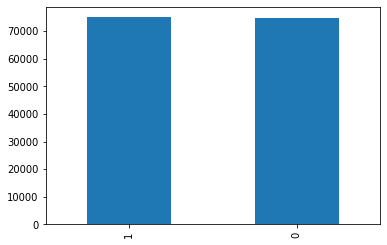

In [ ]:
train_data['label'].value_counts().plot(kind='bar')

In [ ]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  74918
1      1  75013


### 데이터 정제

#### 정규표현식

In [ ]:
# 한글과 공백만 남기기 / 빈 샘플 체크

train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

<ipython-input-14-70a4b47d90fa>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]","")


ratings    0
reviews    0
label      0
dtype: int64


In [ ]:
# test data에도 같은 작업 수행

test_data.drop_duplicates(subset=['reviews'], inplace=True) 
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'].replace("",np.nan,inplace=True)
test_data = test_data.dropna(how='any')
print('전처리 후 테스트용 샘플 수: ', len(test_data))

전처리 후 테스트용 샘플 수:  49977


<ipython-input-15-d28a0339fac5>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


#### 토큰화

In [ ]:
train_data['reviews']

59666     사이즈를 센치씩 늘린건데도 작아요 그리고 색상은 완전 달라요 칙칙한핑크네요ㅠㅠ 많이...
12433                            ㅂ불만족 빗이 아픔  멍이피부에 빗질못해주겟네요
146516    이 제품쓰고 삼일만에 변기물이 잘 안내려갔어요 혹시나해서 다시 빼보니 물이 다시 잘...
158109                                           적당하고 만족합니다
70219                      편하자고 이용하는 밀키튼데 손 은근 많이 가서 저는 패쓰요
                                ...                        
119904    그냥그래요 ㄷㄷㄷㄷ ㅂㅂㅂㅂ 그냥그래요 ㄷㄷㄷㄷ ㅂㅂㅂㅂ ㅁㅁㅁㅁ ㅋㅋㅋㅋ ㅌㅌㅌㅌ...
103714    비싸요 진짜 별거 아니게 허접하게 생겼는데 이게 이만원이라니 진짜 가방 구겨지는것만...
131960                                     장 주문 안됩니다 장 가능해요
146908     하림치킨 여기서 구입하니 엄청 저렴하네요 배송도 쾅꽝 얼어서 도착하고 아주 만족합...
121984                                 조금 약해보이는데 저렴하게 잘 삿어요
Name: reviews, Length: 149931, dtype: object

In [ ]:
mecab = Mecab()
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [ ]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [s for s in x if s not in stopwords])

test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['reviews'].apply(lambda x: [s for s in x if s not in stopwords])

In [ ]:
train_data['tokenized']

59666     [사이즈, 센치, 씩, 늘린, 건데, 작, 아요, 그리고, 색상, 완전, 달라요, ...
12433         [ㅂ, 불, 만족, 빗이, 아픔, 멍, 피부, 빗, 질, 못해, 주, 겟, 네요]
146516    [제품, 쓰, 삼, 일, 만, 변기, 물, 잘, 안, 내려갔, 어요, 혹시나, 해서...
158109                                        [적당, 만족, 합니다]
70219      [편하, 자고, 이용, 밀키, 튼, 데, 손, 은근, 많이, 서, 저, 패, 쓰, 요]
                                ...                        
119904    [그냥, 그래요, ㄷ, ㄷ, ㄷ, ㄷ, ㅂ, ㅂ, ㅂ, ㅂ, 그냥, 그래요, ㄷ, ...
103714    [비싸, 요, 진짜, 별거, 아니, 허접, 생겼, 는데, 이게, 만, 원, 라니, ...
131960                           [장, 주문, 안, 됩니다, 장, 가능, 해요]
146908    [하림, 치킨, 여기, 서, 구입, 니, 엄청, 저렴, 네요, 배송, 쾅, 꽝, 얼...
121984                       [조금, 약해, 보이, 는데, 저렴, 잘, 삿, 어요]
Name: tokenized, Length: 149931, dtype: object

stopwords에 있는 단어들은 제거되고 잘 토큰화 되었다.

#### 단어와 길이 분포 확인

In [ ]:
negative_words = np.hstack(train_data[train_data.label==0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label==1]['tokenized'].values)

평점 1,2 점으로 부정적 리뷰들의 토큰들 카운트

In [ ]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 31799), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('좋', 9812), ('배송', 9677), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7984)]


평점 4,5 점으로 긍정적 리뷰들의 토큰 카운트

In [ ]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39488), ('아요', 21184), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


긍정 리뷰 평균 길이:  13.587751456414221
부정 리뷰의 평균 길이 : 17.029525614672043


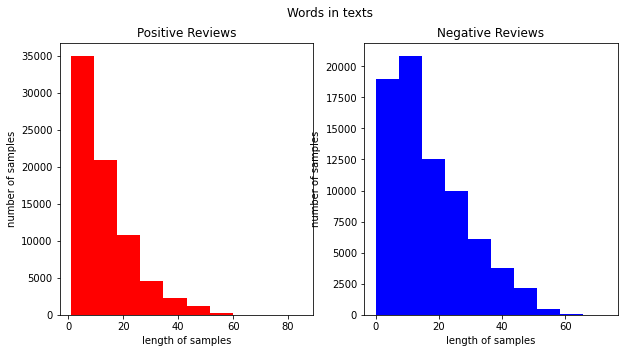

In [ ]:
# 길이 분포 확인

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x:len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰 평균 길이: ', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x:len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))

plt.show()

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [ ]:
X_train

array([list(['사이즈', '센치', '씩', '늘린', '건데', '작', '아요', '그리고', '색상', '완전', '달라요', '칙칙', '핑크', '네요', 'ㅠㅠ', '많이', '아쉽', '지만', '암막', '효과', '좋', '아요']),
       list(['ㅂ', '불', '만족', '빗이', '아픔', '멍', '피부', '빗', '질', '못해', '주', '겟', '네요']),
       list(['제품', '쓰', '삼', '일', '만', '변기', '물', '잘', '안', '내려갔', '어요', '혹시나', '해서', '다시', '빼', '보', '니', '물', '다시', '잘', '내려가', '네요', '많', '걸', '어쩌', '나요', '반품', '싶']),
       ..., list(['장', '주문', '안', '됩니다', '장', '가능', '해요']),
       list(['하림', '치킨', '여기', '서', '구입', '니', '엄청', '저렴', '네요', '배송', '쾅', '꽝', '얼', '어서', '도착', '아주', '만족', '합니다', 'ㅋㅋ']),
       list(['조금', '약해', '보이', '는데', '저렴', '잘', '삿', '어요'])], dtype=object)

#### 정수 인코딩

In [ ]:
# 훈련 데이터에 대해 단어 집합 만들기

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
tokenizer.word_index

{'네요': 1,
 '좋': 2,
 '어요': 3,
 '는데': 4,
 '아요': 5,
 '잘': 6,
 '있': 7,
 '구매': 8,
 '안': 9,
 '배송': 10,
 '습니다': 11,
 '했': 12,
 '너무': 13,
 '같': 14,
 '거': 15,
 '어': 16,
 '먹': 17,
 '합니다': 18,
 '되': 19,
 '재': 20,
 '요': 21,
 '기': 22,
 '쓰': 23,
 '않': 24,
 '없': 25,
 '것': 26,
 '아': 27,
 '해서': 28,
 '사용': 29,
 '로': 30,
 '았': 31,
 '나': 32,
 '으로': 33,
 '만': 34,
 '보다': 35,
 '었': 36,
 '주': 37,
 '겠': 38,
 '지만': 39,
 '보': 40,
 '아서': 41,
 '그냥': 42,
 '해': 43,
 '서': 44,
 '제품': 45,
 '면': 46,
 '어서': 47,
 '가격': 48,
 '해요': 49,
 '좀': 50,
 '만족': 51,
 '생각': 52,
 '주문': 53,
 '입니다': 54,
 '라': 55,
 '더': 56,
 '받': 57,
 '니': 58,
 '맛': 59,
 '할': 60,
 '많이': 61,
 '개': 62,
 '사': 63,
 '때': 64,
 '시': 65,
 '사이즈': 66,
 '에서': 67,
 '빠르': 68,
 '왔': 69,
 '샀': 70,
 '번': 71,
 '작': 72,
 '별로': 73,
 '음': 74,
 '맛있': 75,
 'ㅠㅠ': 76,
 '포장': 77,
 '입': 78,
 '수': 79,
 '두': 80,
 '맞': 81,
 '던': 82,
 '다른': 83,
 '저렴': 84,
 '괜찮': 85,
 '세요': 86,
 '넘': 87,
 '못': 88,
 '상품': 89,
 '정말': 90,
 '하나': 91,
 '아니': 92,
 '에요': 93,
 'ㅠ': 94,
 '냄새': 95,
 '데': 96,
 '부

In [ ]:
threshold=2
total_cnt = len(tokenizer.word_index) #vocab수
rare_cnt=0  #등장빈도 threshold 미만인 단어 수 카운트
total_freq =0   #훈련 데이터의 전체 단어 빈도수 총합
rare_freq = 0   #등장빈도 threshold 미만인 단어의 등장 빈도수 총합

for key, value in tokenizer.word_counts.items():
    total_freq += value

    if (value < threshold):
        rare_cnt += 1
        rare_freq += value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장빈도가 %s번 이하인 희귀 단어의 수: %s' %(threshold-1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율:', (rare_cnt/total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:', (rare_freq/total_freq)*100)

단어 집합(vocabulary)의 크기 : 39997
등장빈도가 1번 이하인 희귀 단어의 수: 18212
단어 집합에서 희귀 단어의 비율: 45.53341500612546
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.79352492030765


In [ ]:
# 전체 단어 중 등장 빈도 2 미만인 단어 제거할 것
vocab_size = total_cnt - rare_cnt + 2 #0번 패딩 토큰, OOV토큰 고려해서 +2
print("단어 집합 크기:", vocab_size)

단어 집합 크기: 21787


In [ ]:
'''토크나이저로 텍스트 시퀀스를 숫자 시퀀스로 변환
   정수 인코딩에서 이보다 큰 숫자 부여된 단어는 OOV로 변환'''

tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])
print(X_test[:3])

[[67, 2060, 299, 14260, 263, 73, 6, 236, 168, 137, 805, 2951, 625, 2, 77, 62, 207, 40, 1343, 155, 3, 6], [482, 409, 52, 8530, 2561, 2517, 339, 2918, 250, 2357, 38, 473, 2], [46, 24, 825, 105, 35, 2372, 160, 7, 10, 8061, 4, 1319, 29, 140, 322, 41, 59, 160, 140, 7, 1916, 2, 113, 162, 1379, 323, 119, 136]]
[[721, 581, 1, 704, 1, 767, 1, 116, 1, 434, 1832, 522, 3516, 1935, 59], [956, 991, 1, 1, 1302, 1, 113, 1, 640, 56, 22], [410, 3327, 1, 1274, 2079, 22, 1, 5418, 290, 134, 1, 3, 27, 1, 15, 28, 22, 1, 513, 1, 449, 17, 33, 1, 618, 1342, 1, 33, 59, 1, 7, 1, 22]]


#### 패딩

서로 다른 길이의 샘플들의 길이를 동일하게 맞처주기 위한 것

In [ ]:
print("리뷰 최대 길이: ", max(len(l) for l in X_train))
print("리뷰 평균 길이: ", sum(map(len, X_train))/len(X_train))

리뷰 최대 길이:  85
리뷰 평균 길이:  15.30754813881052


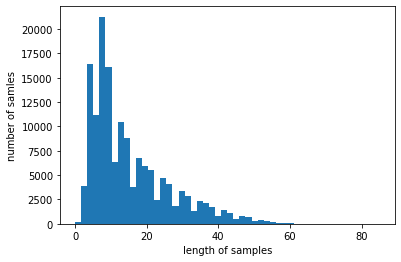

In [ ]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samles')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
    cnt=0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt += 1
    print("전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s" %(max_len, (cnt/len(nested_list))*100))

In [ ]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [ ]:
# 길이 80으로 패딩
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
X_train

array([[  0,   0,   0, ..., 155,   3,   6],
       [  0,   0,   0, ...,  38, 473,   2],
       [  0,   0,   0, ..., 323, 119, 136],
       ...,
       [  0,   0,   0, ..., 438, 477,  50],
       [  0,   0,   0, ...,  52,  19, 185],
       [  0,   0,   0, ...,   7, 503,   4]], dtype=int32)

### GRU로 감성분류

In [ ]:
from keras.layers import Embedding, Dense, GRU
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
gru_model = Sequential()
gru_model.add(Embedding(input_dim= vocab_size,output_dim= 100))
gru_model.add(GRU(128))
gru_model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

gru_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = gru_model.fit(X_train, y_train, epochs=15, callbacks=[es,mc], batch_size=60, validation_split=.2)

Epoch 1/15
 338/2000 [====>.........................] - ETA: 4:34 - loss: 0.3606 - acc: 0.8541

KeyboardInterrupt: ignored

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" %(loaded_model.evaluate(X_test, y_test)[1]))

### 리뷰 예측

In [ ]:
def sentiment_predict(new_sent):
    new_sent = mecab.morphs(new_sent) #토큰화
    new_sent = [w for w in new_sent if not w in stopwords]  #불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sent])  #정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len)  #패딩
    score = float(loaded_model.predict(pad_new))    #예측

    if (score>.5):
        print("{:.2f}%확률로 긍정 리뷰입니다. ".format(score*100))
    else:
        print("{:.2f}%확률로 부정 리뷰입니다. ".format((1-score)*100))

In [ ]:
sentiment_predict("또 사고 싶어요. 추천해요")

96.29%확률로 긍정 리뷰입니다. 


In [ ]:
sentiment_predict("너무 별로에요 이걸 누가 사요")

99.48%확률로 부정 리뷰입니다. 


In [ ]:
sentiment_predict("리뷰 쓸 가치도 없어요")

91.96%확률로 부정 리뷰입니다. 
